# Generate STAC catalog

(Descending track 121)

In [1]:
BURST = '121'

In [2]:
import hyp3_sdk as sdk
import xarray as xr
import geopandas as gpd
import pandas as pd
import odc.stac
import pystac
import concurrent.futures
from utils import hyp32stac, create_collection
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Look up fileURLs from HYP3 SDK
hyp3 = sdk.HyP3() 
myjobs = hyp3.find_jobs(job_type='INSAR_ISCE_BURST')
df = pd.DataFrame([x.to_dict() for x in myjobs])
df.status_code.value_counts()

status_code
SUCCEEDED    541
FAILED         2
Name: count, dtype: int64

In [5]:
df['refdate'] = pd.to_datetime(df['name'].str[15:23], format='%Y%m%d', errors='coerce')
df = df[df['refdate'].notna()] # drop rows with NaT

df['secdate'] = pd.to_datetime(df['name'].str[24:32], format='%Y%m%d', errors='coerce')
df['timespan'] = df.secdate - df.refdate

df = df.sort_values(by='refdate').reset_index()

In [6]:
subset = df[df['name'].str.startswith(BURST)]
subset = subset[subset.status_code == 'SUCCEEDED']
#subset = subset[subset.request_time.str.startswith('2023-12-08')]
print(len(subset))

41


In [7]:
burst_id = subset.name.iloc[0][:14]

In [8]:
# For timeseries, we need n_interferograms > n_dates
dates = pd.unique(subset[['refdate', 'secdate']].values.ravel())
print(f'{len(subset)} Interferograms')
print(f'{len(dates)} Dates')

41 Interferograms
16 Dates


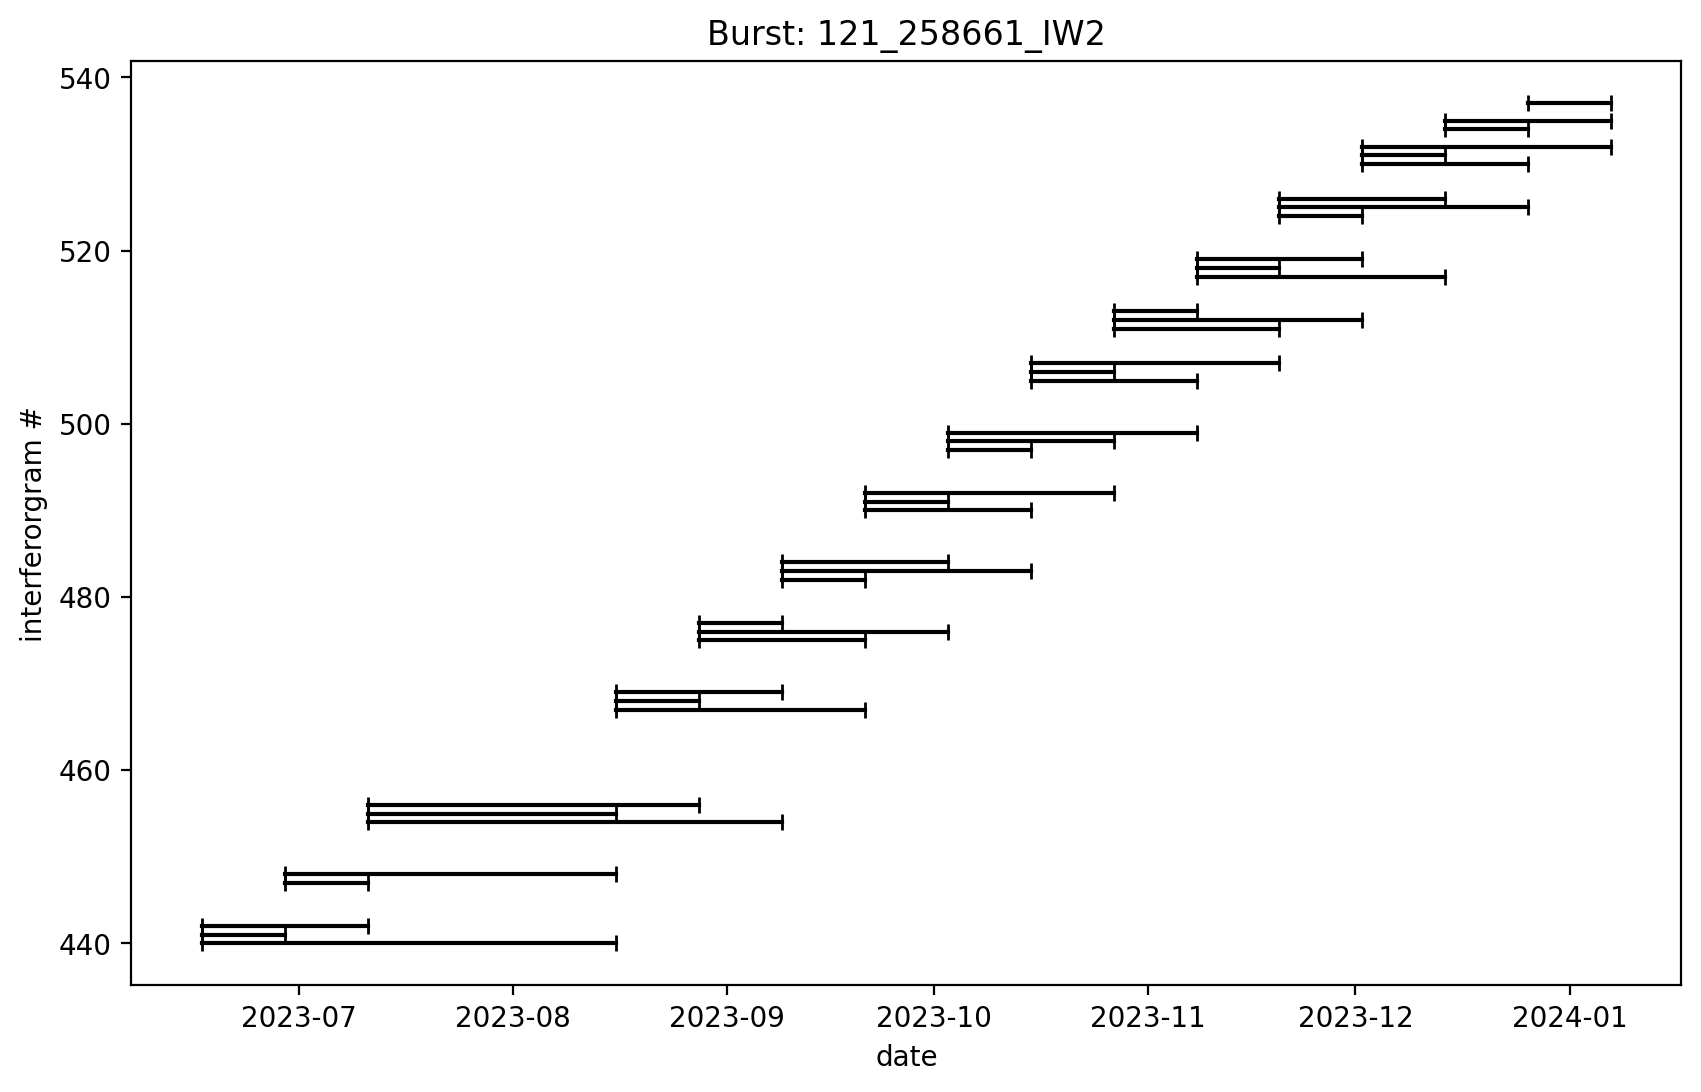

In [9]:
# Plot timespans

fig, ax = plt.subplots(figsize=(10,6))
for i,row in subset.iterrows():
    plt.plot([row.refdate, row.secdate], [i,i],  'k-', marker='|')
    
plt.title(f'Burst: {burst_id}')
plt.ylabel('interferorgram #')
plt.xlabel('date');

#### Uncomment following cells to save STAC metadata

In [ ]:
# %%time 

# args = [job for i,job in subset.iterrows()]

# # TODO: could use a dask dataframe here
# with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
#     results = executor.map(hyp32stac, args)

In [ ]:
# items = list(results)
# print(len(items))

In [ ]:
# Save as ItemCollection

# pystac.ItemCollection(items).save_object(f'{burst_id}.json')

#### Load previously saved STAC metadata

In [10]:
items = pystac.ItemCollection.from_file(f'{burst_id}.json')

In [11]:
DS = odc.stac.load(
    items,
    groupby='id', #unique interferogram identifier, note might have duplicate time coordinates
    chunks={'x': 256*4, 'y': 256*4},
)
DS  

<xarray.Dataset>
Dimensions:      (y: 1989, x: 5310, time: 41)
Coordinates:
  * y            (y) float64 3.115e+06 3.115e+06 ... 3.075e+06 3.075e+06
  * x            (x) float64 4.077e+05 4.077e+05 ... 5.138e+05 5.139e+05
    spatial_ref  int32 32645
  * time         (time) datetime64[ns] 2023-06-17T00:11:46 ... 2023-12-26T00:...
Data variables:
    conncomp     (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    corr         (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    dem          (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lv_phi       (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lv_theta     (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    unwrapped    (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    wrapped      (time, y, x) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

## Static catalog

For now flat catalog of items (w/ burstId subcatalog)
NOTE: currently does not append, just re-writes

In [12]:
CATALOG_ID = 'fufiters'

catalog = pystac.Catalog(id=CATALOG_ID,
                         description='https://github.com/relativeorbit/incubator2024')

collection = create_collection(CATALOG_ID)
catalog.add_child(collection)
collection.add_items(items)
# NOTE: subcatalogs based on STAC properties and datetime pieces
catalog.generate_subcatalogs(template='${burstId}/${year}')
catalog.normalize_hrefs('./')
catalog.validate()
catalog.save(catalog_type=pystac.CatalogType.RELATIVE_PUBLISHED)